Load And Split Data

In [14]:
import pandas as pd

data = pd.read_csv('train.csv', delimiter = ";")  # Load Train datasets
data_test = pd.read_csv('test.csv', delimiter = ";") # Load Test datasets
data_eval = pd.read_csv('evaluation.csv', delimiter=";") # Load Evaluation datasets

# Split Train Data
X_train = data['title'].values + data['text'].values
Y_train = data['label'].values

# Split Test Data
X_test = data_test['title'].values + data_test['text'].values
Y_test = data_test['label'].values

# Split Evaluation Data
X_eval = data_eval['title'].values + data_eval['text'].values
Y_eval = data_eval['label'].values


Tokenization And Preprocessing Data

In [20]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing import sequence

max_len = 350

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>') # Create Instance tokenizer with 5000 words popular
tokenizer.fit_on_texts(X_train) # Build Dictionary based on Train Datasets

# Mapping text -> tokenizer. Sequence -> list[number]
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_eval_sequences = tokenizer.texts_to_sequences(X_eval)

# Padding or Remove for every sequence
X_train_padded = sequence.pad_sequences(X_train_sequences, maxlen=max_len, padding='post')
X_test_padded = sequence.pad_sequences(X_test_sequences, maxlen=max_len, padding='post')
X_eval_padded = sequence.pad_sequences(X_eval_sequences, maxlen=max_len, padding='post')


Build Models LSTM with Keras

In [26]:
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.models import Sequential


model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len), # Embedded input dimension = Dictionary, input length = Sequence max length
    SpatialDropout1D(0.3), # Prunning vector decrease Overfitting
    LSTM(256, dropout=0.2, activation='tanh', recurrent_activation='sigmoid'), # Model LSTM
    Dense(1, activation='sigmoid') # Active Function sigmoid appropriate classified
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # optimize model, loss function and accuracy


Train Model

In [27]:
from keras.callbacks import EarlyStopping
import tensorflow as tf

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # Stop Training When Model Cant Learn

with tf.device('/GPU:0'):
    history = model.fit(X_train_padded, Y_train, validation_data=(X_test_padded, Y_test), # Training with: input - X_train_padded
                    epochs=20, batch_size=128, callbacks=[early_stopping], verbose=1)  #                output - Y_train
                                                                                      #                test - validation_data
                                                                                      #                timesteps - epochs
                                                                                      #                sample size - batch_size
                                                                                      #                optimize - callbacks

Epoch 1/20
191/191 [==============================] - 21s 101ms/step - loss: 0.3656 - accuracy: 0.8520 - val_loss: 0.2084 - val_accuracy: 0.9359
Epoch 2/20
191/191 [==============================] - 19s 99ms/step - loss: 0.1976 - accuracy: 0.9385 - val_loss: 0.2742 - val_accuracy: 0.8742
Epoch 3/20
191/191 [==============================] - 19s 101ms/step - loss: 0.1984 - accuracy: 0.9231 - val_loss: 0.1854 - val_accuracy: 0.9320
Epoch 4/20
191/191 [==============================] - 19s 100ms/step - loss: 0.1821 - accuracy: 0.9291 - val_loss: 0.2008 - val_accuracy: 0.9145
Epoch 5/20
191/191 [==============================] - 19s 100ms/step - loss: 0.3412 - accuracy: 0.8400 - val_loss: 0.4137 - val_accuracy: 0.8353
Epoch 6/20
191/191 [==============================] - 19s 100ms/step - loss: 0.2618 - accuracy: 0.8787 - val_loss: 0.1487 - val_accuracy: 0.9452
Epoch 7/20
191/191 [==============================] - 19s 99ms/step - loss: 0.1409 - accuracy: 0.9469 - val_loss: 0.0992 - val_accu

Model Evaluation

In [28]:
#       With Accuracy
from sklearn.metrics import accuracy_score, classification_report

y_pred_prob = model.predict(X_eval_padded)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(Y_eval, y_pred)
print(f"Độ chính xác của mô hình: {accuracy:.4f}")
print("Báo cáo phân loại:")
print(classification_report(Y_test, y_pred))

254/254 [==============================] - 4s 15ms/step
Độ chính xác của mô hình: 0.9622
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.46      0.47      0.47      3753
           1       0.54      0.52      0.53      4364

    accuracy                           0.50      8117
   macro avg       0.50      0.50      0.50      8117
weighted avg       0.50      0.50      0.50      8117



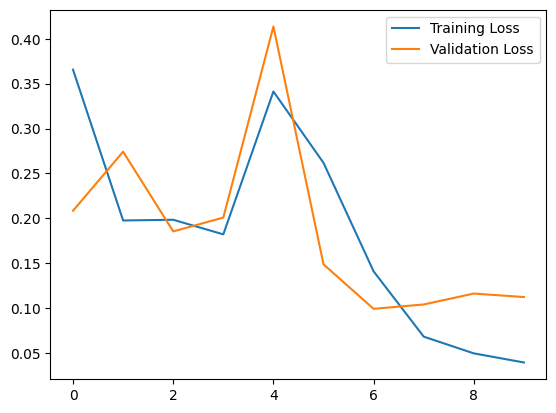

In [29]:
#       With Plot

import matplotlib.pyplot as plt

loss = history.history['loss'] # History of Loss Function
val_loss = history.history['val_loss'] # value of Loss Function

# Show plot

plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend()
plt.show()

Save Models, History Train And Tokenizer

In [30]:
import pickle

model.save('fake_news_lstm.h5') # Save model

with open('tokenizer_lstm.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL) # Save tokenizer

with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f) # Save history